In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
x0 = fd.as_vector([0.5, 0])
h0 = 0.2

In [3]:
def exact_solution(mesh, k, x0):
    x = fd.SpatialCoordinate(mesh)
    z = k * fd.sqrt(fd.inner(x - x0, x - x0))
    u_re = -fd.bessel_Y(0, z) / 4
    u_im = fd.bessel_J(0, z) / 4
    return fd.as_vector([u_re, u_im])

def neumann_bc(mesh, k, x0):
    x = fd.SpatialCoordinate(mesh)
    n = fd.FacetNormal(mesh)
    z = k * fd.sqrt(fd.inner(x - x0, x - x0))
    dzdn = k / fd.sqrt(fd.inner(x - x0, x - x0)) * fd.dot(x - x0, n)
    dudn_re = fd.bessel_Y(1, z) / 4 * dzdn
    dudn_im = -fd.bessel_J(1, z) / 4 * dzdn
    return fd.as_vector([dudn_re, dudn_im])

# Sphere

In [4]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

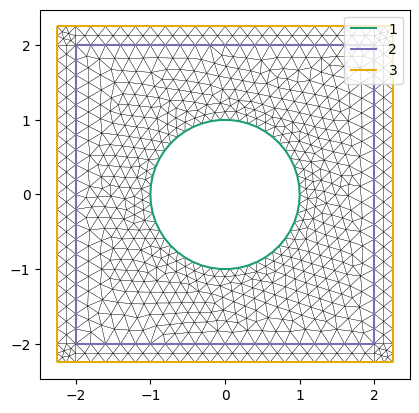

In [5]:
plot_mesh(mesh)

In [6]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


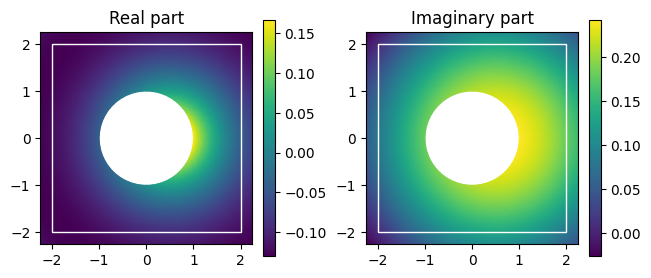

In [7]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


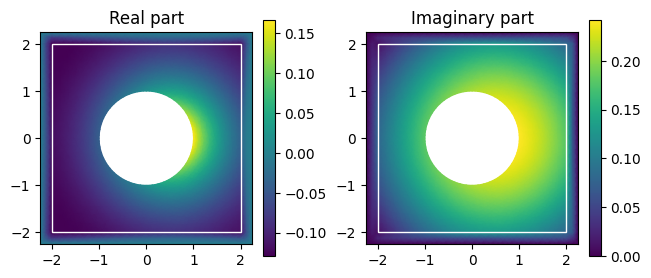

In [8]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [9]:
rel_err = compute_error(u, uh)
print(f"Relative error {rel_err:.2%}")

Relative error 1.30%


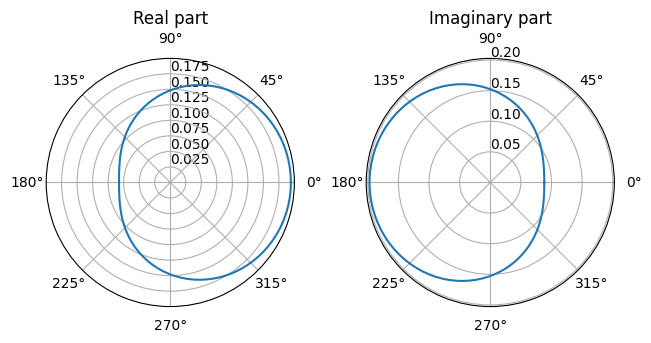

In [10]:
plot_far_field(k, uh)

In [11]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [12]:
"""
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level))
"""
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

angular freqency = 250
refinement level 0, relative error 1.30%
refinement level 1, relative error 0.29%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 1.99%
refinement level 1, relative error 0.63%
refinement level 2, relative error 0.18%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 4.11%
refinement level 1, relative error 1.08%
refinement level 2, relative error 0.30%
refinement level 3, relative error 0.08%
----------------------------------------


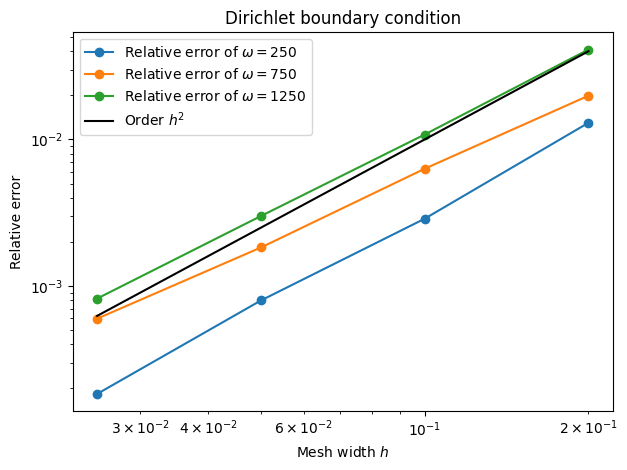

In [13]:
# Dirichlet problem
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.27%
refinement level 1, relative error 0.47%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.45%
refinement level 1, relative error 0.79%
refinement level 2, relative error 0.23%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.85%
refinement level 1, relative error 1.04%
refinement level 2, relative error 0.30%
refinement level 3, relative error 0.08%
----------------------------------------


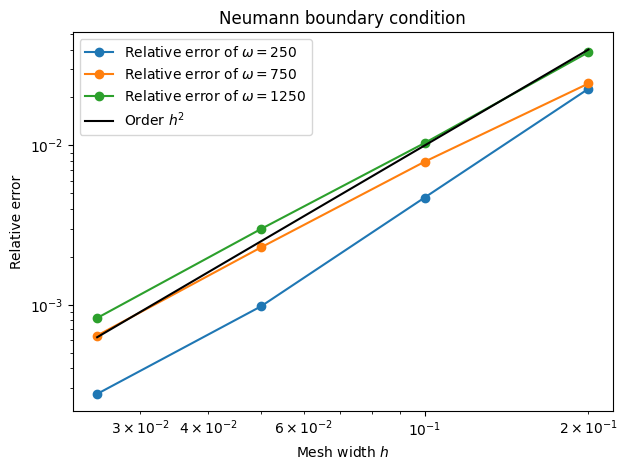

In [14]:
# Neumann problem
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

# Kite

In [15]:
shape = "kite"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

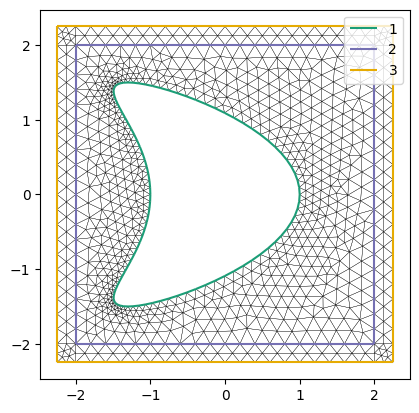

In [16]:
plot_mesh(mesh)

In [17]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


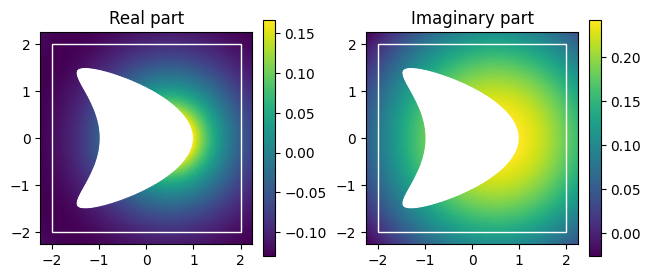

In [18]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


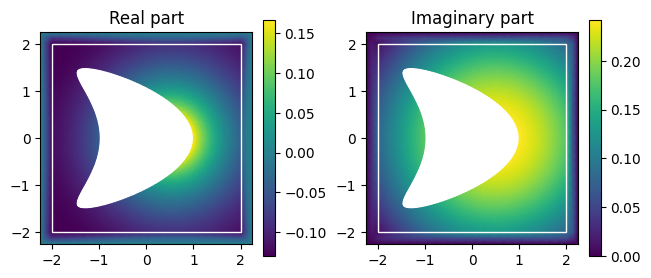

In [19]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [20]:
rel_err = compute_error(u, uh)
print(f"Relative error {rel_err:.2%}")

Relative error 1.36%


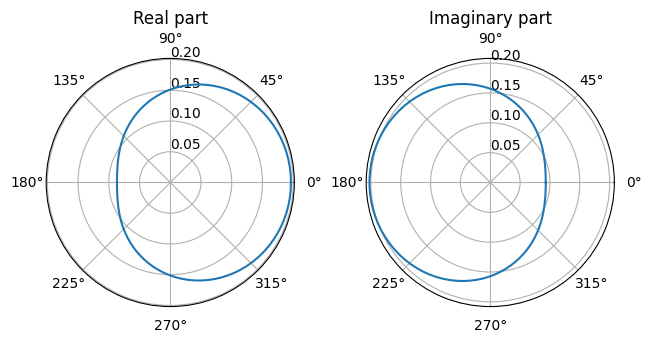

In [21]:
plot_far_field(k, uh)

In [22]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [23]:
"""
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level))
"""
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

angular freqency = 250
refinement level 0, relative error 1.36%
refinement level 1, relative error 0.29%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 1.87%
refinement level 1, relative error 0.58%
refinement level 2, relative error 0.17%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.76%
refinement level 1, relative error 1.02%
refinement level 2, relative error 0.29%
refinement level 3, relative error 0.08%
----------------------------------------


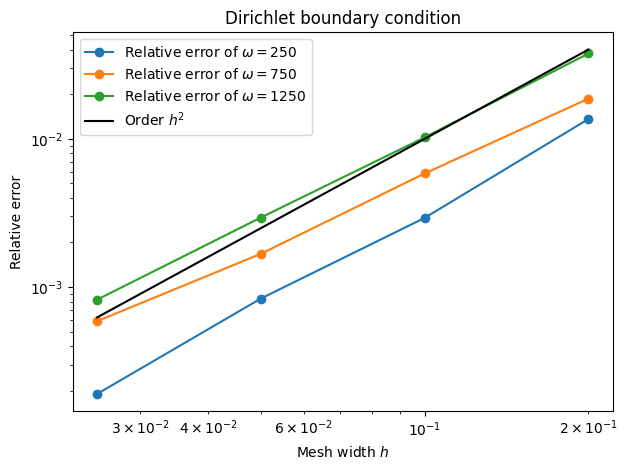

In [24]:
# Dirichlet problem
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.43%
refinement level 1, relative error 0.49%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.84%
refinement level 1, relative error 0.95%
refinement level 2, relative error 0.28%
refinement level 3, relative error 0.07%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.81%
refinement level 1, relative error 1.08%
refinement level 2, relative error 0.33%
refinement level 3, relative error 0.09%
----------------------------------------


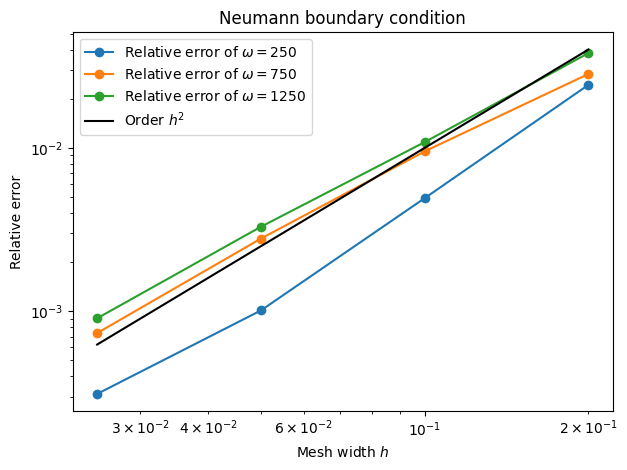

In [25]:
# Neumann problem
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=4)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()